In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import pandas as pd
#from os import listdir
import glob
import sncosmo
from sncosmo.salt2utils import BicubicInterpolator
from ipywidgets import *
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
from tabulate import tabulate # to export in table format
filterwarnings('ignore')
%matplotlib inline

In [19]:
# Kernel of gaussian process
kernel = 0.5 * (RBF(length_scale=3, length_scale_bounds=(1, 30)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,0.5)))

# Read the files

In [20]:
# data files path
data_path = "./data/sp/"
file_names = glob.glob(data_path+"*.dat")
for i in range(0, len(file_names)):
    # rewrite the names 
    file_names[i] = file_names[i][10:]
print("Total files in path: ", len(file_names))

Total files in path:  2466


In [21]:
# auxiliar file containing the phase and name of that spectra
sn_names = pd.read_csv("./data/list.dat",
                       header=None,
                       sep="\s+",
                       names=["name", "phase", "file_name"])
sn_names.head()

,name,phase,file_name
0,Test_SN0,-8.154,Test_SN0_0.dat
1,Test_SN0,-3.522,Test_SN0_1.dat
2,Test_SN0,17.959,Test_SN0_10.dat
3,Test_SN0,19.801,Test_SN0_11.dat
4,Test_SN0,19.816,Test_SN0_12.dat


In [22]:
names = sn_names["name"].unique()
print("Total number of sn files: ", len(names))

Total number of sn files:  171


# Training sample and data visualization

In [23]:
# option to select the sn
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='SN name:',
    disabled=False,
)
display(w)

Dropdown(description='SN name:', options=('Test_SN0', 'Test_SN10', 'Test_SN11', 'Test_SN12', 'Test_SN13', 'Tes…

In [24]:
sn_spectra = glob.glob(data_path + w.value + "*.dat")

In [25]:
def spectra(i=0, plot=True):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    i = index of the element
    returns the wavelength, flux and flux error
    """
    # if plot equals true, return a chosen spectra to plot
    if plot == True:
        data = sncosmo.read_lc(sn_spectra[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]
    # if plot equals false, return an specific spectra 
    else:
        data = sncosmo.read_lc(data_path+file_names[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]


## Spectra

In [26]:
# option list for jupyter lab widgets
optionslist = []
for i in range(0, len(sn_spectra)):
    optionslist.append(i)

def update_graph(i):
    """
    void function that updates a matplotlib graph
    """
    wave, flux, fluxe = spectra(i)
    plt.xlabel("$\lambda$  ($\AA$)")
    plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)")
    plt.plot(wave, flux, "k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Index: ', disabled=False)

widgets.interactive(update_graph,i=i) # to activate the interactive widget

interactive(children=(Dropdown(description='Index: ', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Figures

In [27]:

wave_hist_plot = []
time_hist_plot = []
for i in range(0, len(names)):
    sn_spectra = glob.glob(data_path + names[i] + "*.dat")
    for j in range(0, len(sn_spectra)):
        phase = sn_names["phase"][sn_names["file_name"] == str(sn_spectra[j][10:])]
        wave_array, flux, fluxe = spectra(j)
        for k in range(0, len(wave_array)):
            wave_hist_plot.append(wave_array[k])
            time_hist_plot.append(float(phase))


In [28]:
#len(time_hist_plot)

In [29]:
#len(wave_hist_plot)

In [30]:
xedges = np.linspace(-15, 55, 10)
yedges = np.linspace(2000, 9000, 10)

H, xedges, yedges = np.histogram2d(time_hist_plot, wave_hist_plot, bins=(xedges, yedges))

In [31]:
H = H*171/np.max(H)

In [32]:
min(wave_hist_plot)

3305.0

In [33]:
max(wave_hist_plot)

8586.0

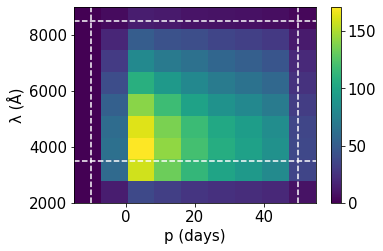

In [119]:
plt.rcParams.update({"font.size": 15})
plt.figure()
plt.pcolormesh(xedges, yedges, H, cmap="viridis")
plt.colorbar()
plt.xlabel("p (days)")
plt.ylabel("λ (Å)")
plt.axhline(y=3500, color='w', linestyle='--')
plt.axhline(y=8500, color='w', linestyle='--')
plt.axvline(x=-10, color='w', linestyle='--')
plt.axvline(x=50, color='w', linestyle='--')
plt.subplots_adjust(bottom=0.2, left=0.2)
plt.savefig('./images/hist2dplotgrid.png', dpi=200)

In [61]:
spectra_train_0=glob.glob(data_path+"Train_SN0_*.dat")
spectra_train_0.sort()

In [121]:
spectra_train_0

['./data/sp/Train_SN0_0.dat',
 './data/sp/Train_SN0_1.dat',
 './data/sp/Train_SN0_2.dat',
 './data/sp/Train_SN0_3.dat',
 './data/sp/Train_SN0_4.dat',
 './data/sp/Train_SN0_5.dat',
 './data/sp/Train_SN0_6.dat',
 './data/sp/Train_SN0_7.dat',
 './data/sp/Train_SN0_8.dat']

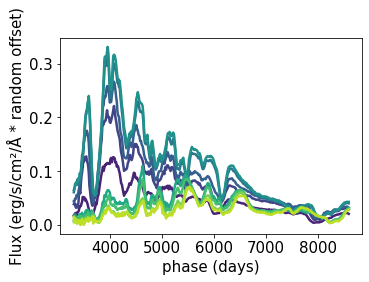

In [120]:
plt.rcParams.update({"font.size": 15})
colors = cm.viridis(np.linspace(0.1, 0.9, len(spectra_train_0)))
for i in range(0, len(spectra_train_0)):
    data = sncosmo.read_lc(spectra_train_0[i], format="salt2")
    phase = float(sn_names["phase"][sn_names["file_name"] == str(spectra_train_0[i][10:])])
    plt.plot(data["WAVE"], data["SN_SPEC"], c=colors[i], linewidth=2.5)
    
plt.xlabel("phase (days)")
plt.ylabel("Flux (erg/s/cm²/Å * random offset)")
plt.subplots_adjust(bottom=0.2, left=0.2)
plt.savefig('./images/spectra_train_01.png', dpi=200)

## Monochromatic light curves

In [11]:
# light curves of that wavelength
wave_number = 7000

time_lc = []
flux_lc = []

for i in range(0, len(sn_spectra)):
    wave, flux, fluxe = spectra(i)
    # interpolate to plot
    flux_lc.append(Spline1d(wave, flux,  k=1)(wave_number))
    time_lc.append(sn_names["phase"][sn_names["file_name"] == str(sn_spectra[i][10:])])

In [ ]:
plt.plot(time_lc, flux_lc, "k.")
plt.xlabel("time (days)")
plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)");

## Training grid

In [ ]:
"""
for i in range(0, len(file_names)):
    wave = spectra(i, plot=False)[0]
    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]
    plt.plot([phase,phase], [np.min(wave),np.max(wave)], 'k', linewidth=1)
    plt.xlabel("time (days)")
    plt.ylabel("$\lambda$ ($\AA$)")
    plt.xlim(-10, 50)
    plt.ylim(3500, 8500)
"""

In [ ]:
## Defining the training grid
X_GRID = np.linspace(-10, 50, 61, dtype=int)
Y_GRID = np.linspace(3500, 8500, 501, dtype=int)

# Grid limits
print("time grid limits: ", np.min(X_GRID), ", ", np.max(X_GRID))
print("wavelenght grid limits: ", np.min(Y_GRID), ", ", np.max(Y_GRID))

In [ ]:
# split our data into a training and test dataset
#np.random.seed(42)
#sn_train, sn_test = train_test_split(names, test_size=0.001)
#print(len(sn_train), len(sn_test))

In [ ]:
def gaussian_process(time, flux, error=True):
    """
    function that performs a gaussian process in a dataset of monochromatic light curves
    wave: Python list that gives the wavelenghts
    flux: np array that gives the flux
    error: binary variable to return or not the covariance in gaussian process regression
    
    return the corresponding gaussian process on data
    """
    # set the gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(time, flux)
    if error==True:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=True) # return mean and covariance
    else:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=False) # return only mean     


In [ ]:
def prepare_data_to_GP(wave):
    """
    function that convert a np array into a Python list for a gaussian process regression in SK-Learn
    wave: np array that gives the wavelenghts
    
    return the wavelenght in a correct format
    """
    temp_wave = [] # a new python list
    for ii in range(0, len(wave)):
        temp_wave.append([wave[ii]]) # correct SK-Learn format
    return temp_wave

In [ ]:
def spectra_train(n_file):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    n_file: file name
    returns the wavelength, flux and flux error
    """
    data = sncosmo.read_lc(n_file, format="salt2")
    return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]

In [ ]:
SPEC_TRAIN_FUN = []
SPEC_TRAIN_TIME = []
SPEC_TRAIN_MINMAX = []
for i in range(0, len(names)):
    SPEC_TRAIN_FUN.append([]) # for spectra function
    SPEC_TRAIN_TIME.append([]) # for spectra time
    SPEC_TRAIN_MINMAX.append([]) # for min max spectra (in wavelenghts)

In [ ]:
for i in range(0, len(names)):
    sn_train_spectra = glob.glob(data_path + names[i] + "_*.dat")
    for j in range(0, len(sn_train_spectra)):
        wave, flux, eflux = spectra_train(sn_train_spectra[j]) # to get wave, flux and flux error
        Nyquist_frequecy=1/15 # approx
        cutoff=1/100 # freq
        #print(cutoff/Nyquist_frequecy)
        b, a = signal.butter(8, cutoff/Nyquist_frequecy, analog=False) # filter
        filtered_flux=signal.filtfilt(b, a, flux, padlen=0)
        SPEC_TRAIN_FUN[i].append(Spline1d(wave, filtered_flux)) # to register the corresponding function
        SPEC_TRAIN_TIME[i].append(float(sn_names["phase"][sn_names["file_name"] == str(sn_train_spectra[j][10:])])) # to regirster the corresponding spectra time
        SPEC_TRAIN_MINMAX[i].append([float(np.min(wave)), float(np.max(wave))]) # min and max wavelength that function is available

In [ ]:
SPEC_GRID = []
for i in range(0, len(names)):
    SPEC_GRID.append([]) # loop for each supernovae in trainingfrom scipy import signal

In [ ]:
for i in range(0, len(SPEC_GRID)):
    for j in range(0, len(Y_GRID)):
        SPEC_GRID[i].append([[], []]) # for each supernovae and for each wavelengh we fill with time and flux lists
#SPEC_GRID[0][1][0]  # first sn, second wave list order, time or flux

In [ ]:
for i in range(0, len(names)): # sn train index
    print(i+1, "/", len(names))
    for j in range(0, len(Y_GRID)): #  grid index
        for k in range(0, len(SPEC_TRAIN_FUN[i])): #func index
            if SPEC_TRAIN_MINMAX[i][k][0] < Y_GRID[j] < SPEC_TRAIN_MINMAX[i][k][1]: # if it's inside the bounds
                SPEC_GRID[i][j][0].append([SPEC_TRAIN_TIME[i][k]]) # time
                SPEC_GRID[i][j][1].append(np.float(SPEC_TRAIN_FUN[i][k](Y_GRID[j]))) # flux from function

In [ ]:
"""
Nsn = 30
Nspec = 100
TIME_TEMP = SPEC_GRID[Nsn][Nspec][0]
FLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)
y_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) 

plt.plot(X_GRID, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color='k')
plt.scatter(TIME_TEMP, FLUX_TEMP, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlabel("time (days)")
plt.ylabel("flux (a.u)")
"""

In [ ]:
data_NSPEC_CUT = 7 # minimum number of spectra
data_NWAVE_CUT = 200 # wavelengh in a commom grid
SN_TRAIN = []
SN_TRAIN_ERROR = []
for i in range(0, len(names)):
        SN_TRAIN.append([])
        SN_TRAIN_ERROR.append([])

In [ ]:
for i in range(0, len(SPEC_GRID)):
    print(i+1, "/", len(SPEC_GRID))
    if len(SPEC_GRID[i][data_NWAVE_CUT][0]) > data_NSPEC_CUT: # apply a cut based on number of spectras
        for j in range(0, len(Y_GRID)):
            TIME_TEMP = SPEC_GRID[i][j][0]
            FLUX_TEMP = SPEC_GRID[i][j][1]
            FLUX_TEMP, FLUX_ERROR_TEMP = gaussian_process(TIME_TEMP, FLUX_TEMP, error=True) # the brand new monochromatic light curves
            FLUX_ERROR_TEMP = np.sqrt(np.diag(FLUX_ERROR_TEMP) # estimate the error on gaussian process
            for k in range(0, len(FLUX_TEMP)): 
                SN_TRAIN[i].append(FLUX_TEMP[k])
                SN_TRAIN_ERROR[i].append(FLUX_ERROR_TEMP[k])

In [ ]:
# organize a grid to export each surface
X_export = []
Y_export = []
for i in range(0, len(Y_GRID)):
    for j in range(0, len(X_GRID)):
        X_export.append(X_GRID[j])
        Y_export.append(Y_GRID[i])

In [ ]:
# path
save_path = 'C:\\Users\\joao\\Documents\\GitHub\\SNFACTORY_SNTRAIN\\SN_surfaces\\'

In [ ]:
for i in range(0, len(names)):
    print(i)
    table = []
    if len(SN_TRAIN[i]) > 0:
        for n in range(0, len(X_export)):
            table.append((X_export[n], Y_export[n], SN_TRAIN[i][n], SN_TRAIN_ERROR[i][n]))

        completeName = os.path.join(save_path, str(names[i])+".dat")

        f = open(completeName, 'w')
        f.write(tabulate(table, tablefmt="plain"))
        f.close()
